In [ ]:
!pip install opendatasets
!pip install pandas

In [ ]:
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/katalniraj/adni-extracted-axial/data")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: architgupta16
Your Kaggle Key: ··········


100%|██████████| 102M/102M [00:06<00:00, 17.3MB/s]


In [ ]:
import pandas as pds
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,DepthwiseConv2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
dataset_dir = '/content/adni-extracted-axial/Axial'

categories = ['AD', 'CI', 'CN']

data = []
labels = []

for category in categories:
    path = os.path.join(dataset_dir, '', category)
    class_num = categories.index(category)

    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        img_array = cv2.resize(img_array, (224, 224))
        data.append([img_array, class_num])

np.random.shuffle(data)


In [ ]:
len(data)

5154

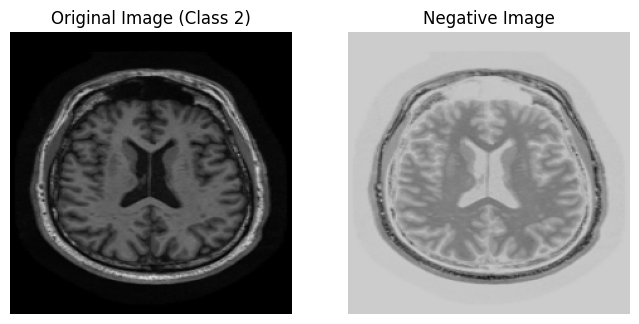

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Get the image and its class label
image_array, class_num = data[125]
# temp = 0.8*image_array

negative_image = (255 - image_array)*0.8
scaled_image = cv2.convertScaleAbs(negative_image)

# Display the original and negative images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title(f'Original Image (Class {class_num})')
plt.imshow(cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f'Negative Image')
plt.imshow(cv2.cvtColor(scaled_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

X = np.array(X)
y = np.array(y)
# out = np.divide(X,255)

y = to_categorical(y, num_classes=len(categories))

n_splits = 1
test_size = 0.2

stratified_split = StratifiedShuffleSplit(n_splits=n_splits,test_size=test_size,random_state=43)

for train_index, test_index in stratified_split.split(X,y):
  X_t, X_test = X[train_index], X[test_index]
  y_t, y_test = y[train_index], y[test_index]

In [ ]:
len(X_t)


4123

In [ ]:
n_splits = 1
test_size = 0.2

stratified_split = StratifiedShuffleSplit(n_splits=n_splits,test_size=test_size,random_state=43)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
for train_index, val_index in stratified_split.split(X_t,y_t):
  X_train, X_val = X_t[train_index], X_t[val_index]
  y_train, y_val = y_t[train_index], y_t[val_index]

In [ ]:
from collections import Counter

train_class_counts = Counter(np.argmax(y_train, axis=1))

val_class_counts = Counter(np.argmax(y_val, axis=1))

test_class_counts = Counter(np.argmax(y_test, axis=1))

print("Training Set Class Counts:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count} samples")

print("\nValidation Set Class Counts:")
for class_label, count in val_class_counts.items():
    print(f"Class {class_label}: {count} samples")

print("\nTest Set Class Counts:")
for class_label, count in test_class_counts.items():
    print(f"Class {class_label}: {count} samples")


Training Set Class Counts:
Class 1: 1657 samples
Class 2: 922 samples
Class 0: 719 samples

Validation Set Class Counts:
Class 1: 415 samples
Class 2: 230 samples
Class 0: 180 samples

Test Set Class Counts:
Class 1: 518 samples
Class 0: 225 samples
Class 2: 288 samples


In [ ]:
print(len(X_train),len(X_test),len(X_val),len(X_t))

3298 1031 825 4123


In [ ]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch,lr):
    if epoch < 8:
        return lr
    else:
        return 0.95*lr

In [ ]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
optimizer = Adam(learning_rate=0.00095)

In [ ]:
from keras import layers
from keras import models

In [ ]:
import tensorflow as tf

In [ ]:
class NegativeLayer(layers.Layer):
  def __init__(self):
    super(NegativeLayer,self).__init__()

  def build(self,input_shape):
    super(NegativeLayer,self).build(input_shape)

  @staticmethod
  def call(inp, **kwargs):
    return tf.negative(inp)*0.8

  def compute_output_shape(self,input_shape):
    return super(NegativeLayer, self).compute_output_shape(input_shape)

In [ ]:
model = Sequential()
inputs = layers.Input(shape=(224, 224, 3), name="Input")

x = layers.BatchNormalization()(inputs)
x = layers.Conv2D(16, (5, 5),padding="same", input_shape=(X.shape[1], X.shape[2], 3), activation='relu')(x)
p1 = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(p1)

x = layers.Conv2D(32, (3, 3), padding="same", activation='relu')(x)
p2 = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(p2)


x = layers.Conv2D(64, (3, 3), padding="same", activation='relu')(x)
p3 =  layers.MaxPooling2D(pool_size=(2, 2))(x)
c1 = layers.BatchNormalization()(p3)


# ----------------------------------------------------------------------------

# p6 = layers.MaxPooling2D(pool_size=(3, 3),strides=(1,1),padding="same")(c1)
# x = layers.Conv2D(64, (1, 1),padding="same", activation='relu')(p6)
# x = layers.BatchNormalization()(x)
n1 = NegativeLayer()(c1)
x = layers.Conv2D(32, (3, 3),padding="same", activation='relu')(n1)
x = layers.BatchNormalization()(x)
p7 = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(64, (3, 3),padding="same", activation='relu')(p7)
x = layers.BatchNormalization()(x)
p8 = layers.MaxPooling2D(pool_size=(2, 2))(x)

# ----------------------------------------------------------------------------




# ----------------------------------------------------------------------------

x = layers.Conv2D(96, (3, 3), padding="same", activation='relu')(c1)
# x = layers.DepthwiseConv2D( (3, 3),padding="same",activation='relu')(x)
p4 = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(p4)

# x = layers.Conv2D(196, (3, 3), padding="same", activation='relu')(x)
# x = layers.DepthwiseConv2D((3,3),padding="same",activation='relu')(x)

# x = layers.Dropout(0.2)(x)
x = layers.Conv2D(128, (3, 3), padding="same", activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
c2 = layers.BatchNormalization()(x)

# p5 = layers.MaxPooling2D(pool_size=(2, 2))(x)

# x = layers.Conv2D(392, (3, 3), padding="same", activation='relu')(p5)
# x = layers.BatchNormalization()(x)

# x = layers.DepthwiseConv2D((3, 3),padding="same",activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.DepthwiseConv2D((3, 3),padding="same",activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.DepthwiseConv2D((3, 3),padding="same",activation='relu')(x)
# c2 = layers.BatchNormalization()(x)



# x = layers.Flatten()(x)
merge_layer = layers.Concatenate()([c2,p8])

x = layers.GlobalAveragePooling2D(name="GAP")(merge_layer)
# print(model.layers[-1].output_shape)

# x = layers.Dense(128, activation='relu')(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dense(64, activation='relu')(x)

# model.add(Dropout(0.2))

outputs = layers.Dense(len(categories), activation='softmax')(x)
model = models.Model(inputs=inputs, outputs=outputs)



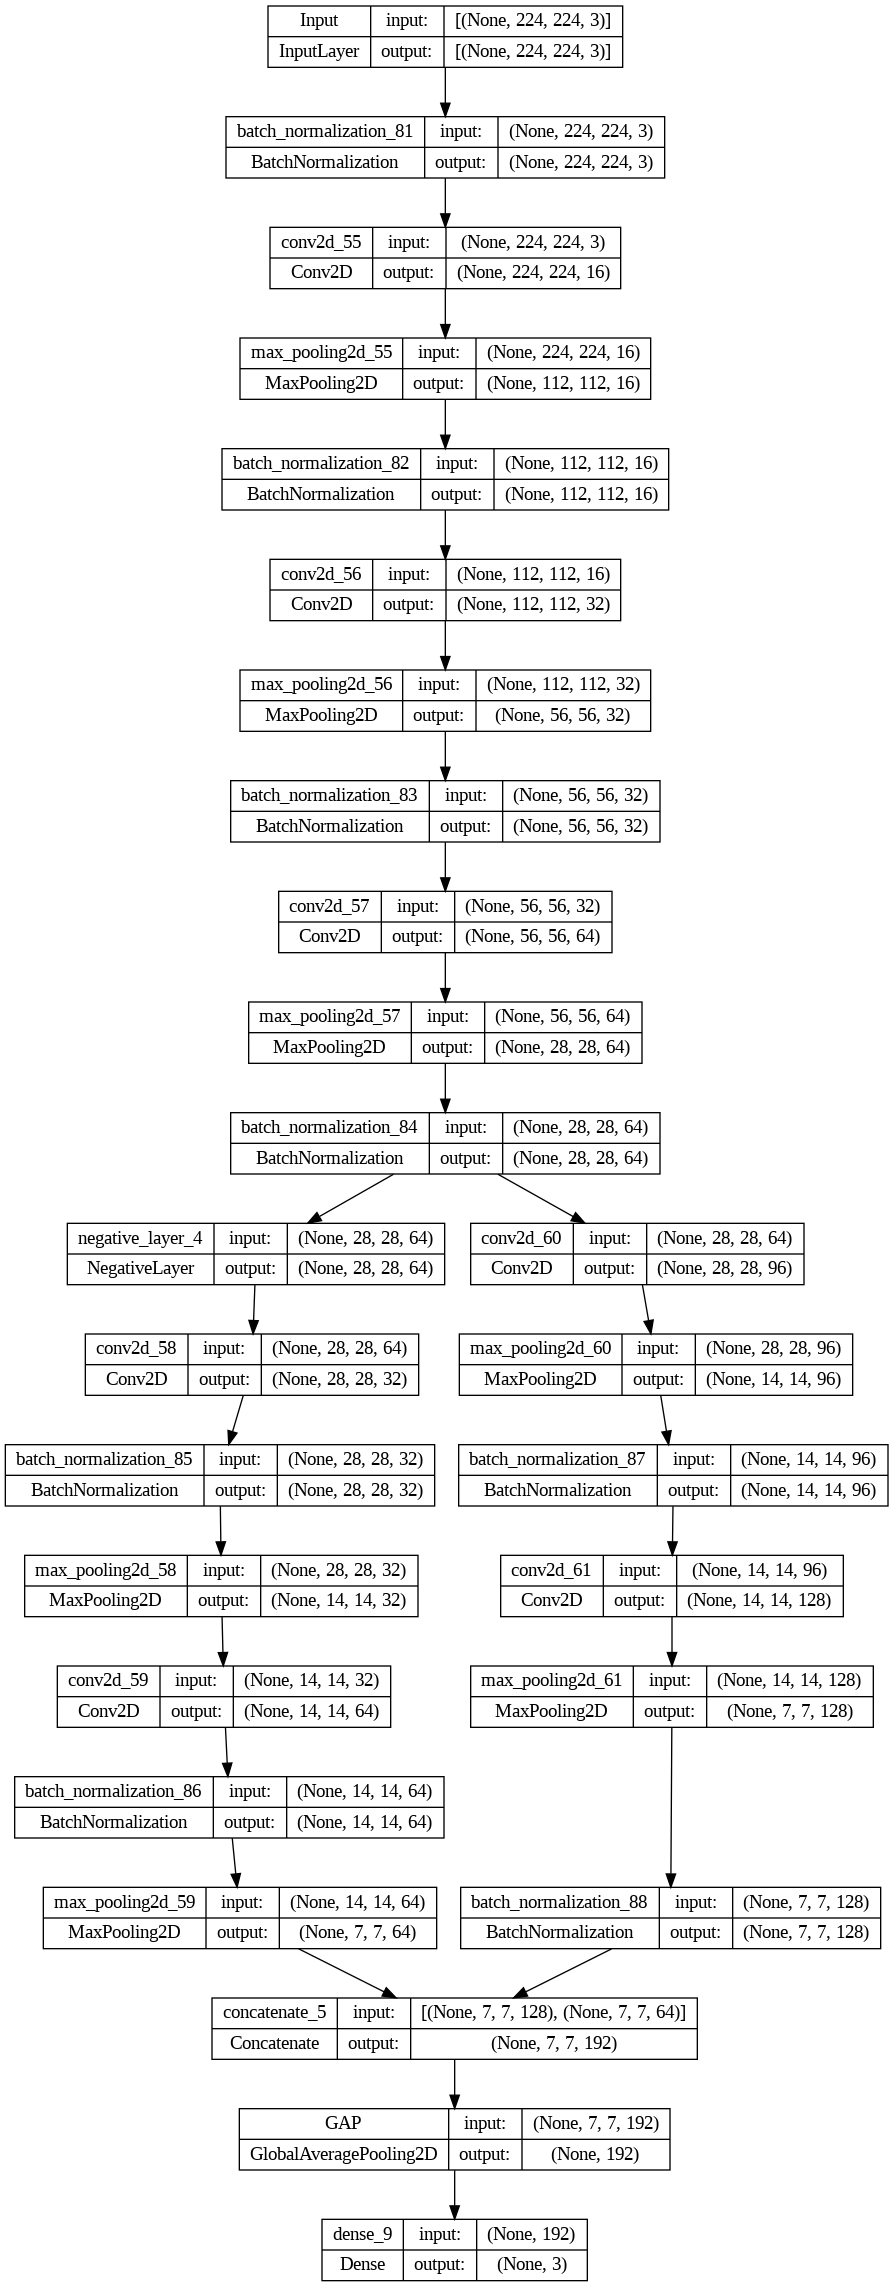

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 batch_normalization_81 (Ba  (None, 224, 224, 3)          12        ['Input[0][0]']               
 tchNormalization)                                                                                
                                                                                                  
 conv2d_55 (Conv2D)          (None, 224, 224, 16)         1216      ['batch_normalization_81[0][0]
                                                                    ']                            
                                                                                            

In [ ]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
class_weights = {0:0.24,1:0.26,2:0.29,3:0.21}

In [ ]:
from keras.callbacks import ReduceLROnPlateau, LambdaCallback

lr_history = []

def record_lr(epoch, logs):
    lr_history.append(model.optimizer.lr.numpy())

lr_recorder = LambdaCallback(on_epoch_end=record_lr)

history = model.fit(
    X_train, y_train,
    batch_size=64,
    validation_data=(X_val, y_val),
    epochs=15,
    callbacks=[lr_scheduler]
)



Epoch 1/15
52/52 [==============================] - 10s 94ms/step - loss: 0.8586 - accuracy: 0.5937 - val_loss: 1.0905 - val_accuracy: 0.5309 - lr: 9.5000e-04
Epoch 2/15
52/52 [==============================] - 4s 83ms/step - loss: 0.5144 - accuracy: 0.8153 - val_loss: 1.8691 - val_accuracy: 0.5309 - lr: 9.5000e-04
Epoch 3/15
52/52 [==============================] - 4s 85ms/step - loss: 0.2498 - accuracy: 0.9309 - val_loss: 3.2657 - val_accuracy: 0.5030 - lr: 9.5000e-04
Epoch 4/15
52/52 [==============================] - 4s 85ms/step - loss: 0.0908 - accuracy: 0.9848 - val_loss: 4.2930 - val_accuracy: 0.5030 - lr: 9.5000e-04
Epoch 5/15
52/52 [==============================] - 4s 85ms/step - loss: 0.0501 - accuracy: 0.9918 - val_loss: 2.3337 - val_accuracy: 0.5467 - lr: 9.5000e-04
Epoch 6/15
52/52 [==============================] - 5s 87ms/step - loss: 0.0245 - accuracy: 0.9979 - val_loss: 4.1105 - val_accuracy: 0.5091 - lr: 9.5000e-04
Epoch 7/15
52/52 [==============================] -

#### Use this for mixed data testing

In [ ]:
# test_labels = to_categorical(test_labels, num_classes=len(categories))

test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_accuracy}")


33/33 [==============================] - 0s 13ms/step - loss: 0.0282 - accuracy: 0.9932
Test Accuracy: 0.99321049451828


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_test, axis=1)

# Generate a classification report
report = classification_report(y_val_classes, y_pred_classes, target_names=categories)

print(report)


33/33 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

          AD       1.00      0.99      0.99       225
          CI       0.99      1.00      0.99       518
          CN       1.00      0.99      0.99       288

    accuracy                           0.99      1031
   macro avg       0.99      0.99      0.99      1031
weighted avg       0.99      0.99      0.99      1031



26/26 [==============================] - 0s 10ms/step


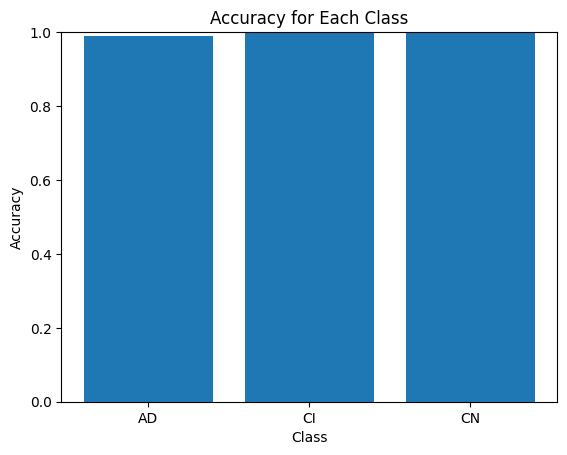

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the validation set
y_pred = model.predict(X_val)

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_val_classes, y_pred_classes)

# Calculate the accuracy for each class
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Plotting
plt.bar(categories, class_accuracies)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Class')
plt.ylim([0, 1])  # Set the limit of y-axis to [0,1] for percentage
plt.show()


In [ ]:
def plot_metrics(hist, metric_name_list):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        hist: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_name_list)

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, len(hist.history[metric_name_list[0]]) + 1)

    for ax, metric_n in zip(axes, metric_name_list):
        metric = hist.history[metric_n]
        v_metric = hist.history[f"val_{metric_n}"]

        ax.plot(rng, metric, label=metric_n)
        ax.plot(rng, v_metric, label=f"val_{metric_n}")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_n in ("auc", "mcc"):
            ax.set_ylabel(metric_n.upper())
            ax.set_title(metric_n.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_n.capitalize())
            ax.set_title(metric_n.capitalize() + " vs Epochs")

        max_loss = max(max(metric), max(v_metric))
        min_loss = min(min(metric), min(v_metric))
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()

    plt.show()

In [ ]:
import math
metric_names = ["loss", "accuracy","f1_score",
                "specificity", "sensitivity", "mcc"]
plot_metrics(history, metric_names)